####  **Variational autoencoder for text matching via Pytorch**
- Unsupervised sequence learning and semi-supervised learning for SNLI dataset are implemented.

In [0]:
# packages and data import
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe

from nltk import word_tokenize
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### **Glove NLP model from Stanford University**
- GloVe: Global Vectors for Word Representation: 
  - https://nlp.stanford.edu/pubs/glove.pdf
  - https://nlp.stanford.edu/projects/glove/
  - https://nlp.stanford.edu/projects/snli/
- Matrix P of word-word co-occurrence X:
  - Entry Xij tabulate the number of times word j occurs in the context of word i. 
  - Pij = P(j|i) = Xij/Xi be the probability that word j appear in the context of word i
-  Nearest neighbors measure
  - The Euclidean distance (or cosine similarity) between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words. 

In [0]:
!pip install json-lines

In [0]:
import json_lines

with open('snli_1.0_dev.jsonl', 'rb') as f: # opening file in binary(rb) mode    
   for item in json_lines.reader(f):
       print(item) #or use print(item['X']) for printing specific data
       break
with open('snli_1.0_test.jsonl', 'rb') as f: # opening file in binary(rb) mode    
   for item in json_lines.reader(f):
       print(item) #or use print(item['X']) for printing specific data
       break

{'annotator_labels': ['neutral', 'entailment', 'neutral', 'neutral', 'neutral'], 'captionID': '4705552913.jpg#2', 'gold_label': 'neutral', 'pairID': '4705552913.jpg#2r1n', 'sentence1': 'Two women are embracing while holding to go packages.', 'sentence1_binary_parse': '( ( Two women ) ( ( are ( embracing ( while ( holding ( to ( go packages ) ) ) ) ) ) . ) )', 'sentence1_parse': '(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP are) (VP (VBG embracing) (SBAR (IN while) (S (NP (VBG holding)) (VP (TO to) (VP (VB go) (NP (NNS packages)))))))) (. .)))', 'sentence2': 'The sisters are hugging goodbye while holding to go packages after just eating lunch.', 'sentence2_binary_parse': '( ( The sisters ) ( ( are ( ( hugging goodbye ) ( while ( holding ( to ( ( go packages ) ( after ( just ( eating lunch ) ) ) ) ) ) ) ) ) . ) )', 'sentence2_parse': '(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP are) (VP (VBG hugging) (NP (UH goodbye)) (PP (IN while) (S (VP (VBG holding) (S (VP (TO to) (VP (VB go) (NP (N

#### **Details for torchtext data class**
- https://torchtext.readthedocs.io/en/latest/data.html
- data.Field: defines a datatype together with instructions for converting to Tensor.
  - Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

#### **Additional: torchtext data experiment**
- https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84
- data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Another complete tutorial: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

In [0]:
# data
class SNLI():
  def __init__(self, args):
    # batch_first: whether to produce tensors with the batch dimension first
    # tokenize: function used to tokenize strings using this field into sequential examples. If “spacy”, the SpaCy tokenizer is used
    # fix_length: fixed length that all examples using this field will be padded to
    self.TEXT = data.Field(batch_first=True, tokenize=word_tokenize, lower=True, fix_length=29)
    # sequential:specify that this column holds sequences
    self.LABEL = data.Field(sequential=False, unk_token=None)
    # https://torchtext.readthedocs.io/en/latest/datasets.html#snli
    self.train, self.dev, self.test = datasets.SNLI.splits(self.TEXT, self.LABEL)

    # construct the Vocab object for this field from one or more datasets.
    # build the vocabulary so we can convert tokens/words into integer numbers later
    self.TEXT.build_vocab(self.train, self.dev, self.test, vectors=GloVe(name='840B', dim=300))
    self.LABEL.build_vocab(self.train)

    # BucketIterator: defines an iterator that batches examples of similar lengths together
    # device: device to create batches on. Use -1 for CPU and None for the currently active GPU device
    self.train_iter, self.dev_iter, self.test_iter = data.BucketIterator.splits((self.train, self.dev, self.test), 
                                                                                batch_size=args.batch_size, device=args.gpu)

In [0]:
TEXT = data.Field(batch_first=True, tokenize=word_tokenize, lower=True, fix_length=29)
LABEL = data.Field(sequential=False, unk_token=None)
train, dev, test = datasets.SNLI.splits(TEXT, LABEL)

In [0]:
# dev
print(dev[0])
print(len(dev))
print(dev[0].__dict__.keys())
print(dev[0].premise)
print(dev[0].hypothesis)
print(dev[0].label)
# train and test
print(train[0].__dict__.keys())
print(len(train))
print(train[0].label)
print(test[0].__dict__.keys())
print(len(test))
print(test[0].label)

9842
dict_keys(['premise', 'hypothesis', 'label'])
['two', 'women', 'are', 'embracing', 'while', 'holding', 'to', 'go', 'packages', '.']
['the', 'sisters', 'are', 'hugging', 'goodbye', 'while', 'holding', 'to', 'go', 'packages', 'after', 'just', 'eating', 'lunch', '.']
neutral
dict_keys(['premise', 'hypothesis', 'label'])
549367
neutral
dict_keys(['premise', 'hypothesis', 'label'])
9824
neutral


#### **torch.nn.Conv2d**
- https://pytorch.org/docs/stable/nn.html

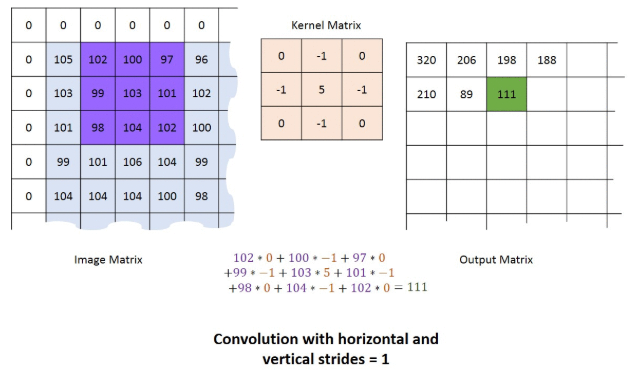

In [0]:
# Kernel size explanation
from IPython.display import Image
Image("kernel size.PNG")

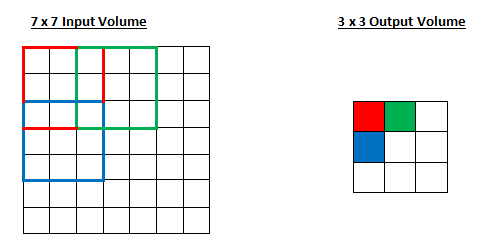

In [0]:
from IPython.display import Image
Image("stride.PNG")
# stride controls how the filter convolves around the input volume

In [17]:
# squeeze and unsqueeze: delete and add dimensions at certain location - index starts from zero
a = torch.rand(2, 3)
print(a.shape)
print(a)
b = torch.unsqueeze(a, 1)
print(b.shape)
print(b)
c = torch.unsqueeze(b, 0)
print(c.shape)
print(c)

torch.Size([2, 3])
tensor([[0.2117, 0.9329, 0.8882],
        [0.2283, 0.5948, 0.2738]])
torch.Size([2, 1, 3])
tensor([[[0.2117, 0.9329, 0.8882]],

        [[0.2283, 0.5948, 0.2738]]])
torch.Size([1, 2, 1, 3])
tensor([[[[0.2117, 0.9329, 0.8882]],

         [[0.2283, 0.5948, 0.2738]]]])


#### **Basic Convolution Encoder and Decoder class**

In [0]:
# Module class encoder and decoder:
# torch.nn.Module: Base class for all neural network modules.
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
# Applies a 2D convolution over an input signal composed of several input planes.

class ConvolutionEncoder(nn.Module):
	def __init__(self, args):
		super(ConvolutionEncoder, self).__init__()
  # kernel_size (int or tuple): Size of the convolving kernel
  # stride (int or tuple, optional): Stride of the convolution. Default: 1
		self.conv1 = nn.Conv2d(1, args.feature_maps[0], (args.filter_size, args.word_dim), stride=args.stride)
		self.conv2 = nn.Conv2d(args.feature_maps[0], args.feature_maps[1], (args.filter_size, 1), stride=args.stride)
		self.conv3 = nn.Conv2d(args.feature_maps[1], args.feature_maps[2], (args.filter_size, 1), stride=args.stride)
    # rectifier(activation function) defined as the positive part of its argument
		self.relu = nn.ReLU()

	def forward(self, x):
		# reshape for convolution layer
		x.unsqueeze_(1)
		h1 = self.relu(self.conv1(x))
		h2 = self.relu(self.conv2(h1))
		h3 = self.relu(self.conv3(h2))
		# (batch, feature_maps[2])
		h3.squeeze_()
		if len(h3.size()) < 2:
			h3.unsqueeze_(0)
		return h3

class DeconvolutionDecoder(nn.Module):
	def __init__(self, args):
		super(DeconvolutionDecoder, self).__init__()
		self.deconv1 = nn.ConvTranspose2d(args.latent_size, args.feature_maps[1], (args.filter_size, 1), stride=args.stride)
		self.deconv2 = nn.ConvTranspose2d(args.feature_maps[1], args.feature_maps[0], (args.filter_size, 1), stride=args.stride)
		self.deconv3 = nn.ConvTranspose2d(args.feature_maps[0], 1, (args.filter_size, args.word_dim), stride=args.stride)
		self.relu = nn.ReLU()

	def forward(self, z):
		# reshape for deconvolution layer
		z = z.unsqueeze(-1).unsqueeze(-1)
		h2 = self.relu(self.deconv1(z))
		h1 = self.relu(self.deconv2(h2))
		x_hat = self.relu(self.deconv3(h1))
		# (batch, seq_len, word_dim)
		x_hat.squeeze_()
		if len(x_hat.size()) < 3:
			x_hat.unsqueeze_(0)
		return x_hat

In [19]:
# nn.Linear: applies a linear transformation to the incoming data - y=xA^T+b
m = nn.Linear(20, 30)
input_ = torch.randn(128, 20)
output = m(input_)
print(output.size())

# nn.Dropout: 
# During training, randomly zeroes some of the elements of the input
# tensor with probability :attr:`p` using samples from a Bernoulli distribution
m = nn.Dropout(p=0.4)
input_ = torch.randn(5, 5)
output = m(input_)
print(output)

torch.Size([128, 30])
tensor([[ 3.6193,  0.0000, -0.8486, -1.2999,  0.0000],
        [-0.9898, -0.9549, -0.6381,  2.6899, -0.0000],
        [-0.9433, -3.6226,  0.0000,  0.0000,  2.7049],
        [-0.0000, -0.2302, -0.0000, -0.6319, -0.1670],
        [ 0.4955, -0.0000,  1.4237,  2.5574,  0.2916]])


In [20]:
## torch.bmm: batch matrix-multiplication
cc=torch.randn((2,2,5))
print(cc)
dd=torch.reshape(cc,(2,5,2))
print(dd)
e=torch.bmm(cc,dd)
print(e)
e.size()
# decompose 
print(torch.mm(cc[0,:,:], dd[0,:,:]))
print(torch.mm(cc[1,:,:], dd[1,:,:]))

tensor([[[ 0.2927,  0.3490, -2.4887, -2.2404,  2.2300],
         [-1.2330, -1.4926,  0.3051, -1.5265, -0.5048]],

        [[ 1.9837,  0.1778, -0.0176, -0.0604,  0.2230],
         [ 0.5170, -0.6095, -0.6086, -0.8372, -1.1075]]])
tensor([[[ 0.2927,  0.3490],
         [-2.4887, -2.2404],
         [ 2.2300, -1.2330],
         [-1.4926,  0.3051],
         [-1.5265, -0.5048]],

        [[ 1.9837,  0.1778],
         [-0.0176, -0.0604],
         [ 0.2230,  0.5170],
         [-0.6095, -0.6086],
         [-0.8372, -1.1075]]])
tensor([[[-6.3929,  0.5797],
         [ 7.0830,  2.3267]],

        [[ 3.7781,  0.1226],
         [ 2.3380,  1.5501]]])
tensor([[-6.3929,  0.5797],
        [ 7.0830,  2.3267]])
tensor([[3.7781, 0.1226],
        [2.3380, 1.5501]])


In [21]:
# torch.unsqueeze_(-1).expand()
a = torch.Tensor([[0,1,2],[3,4,5],[6,7,8]])
print(a.shape)
print(a)
a.unsqueeze_(-1)
print(a.shape)
print(a)
a = a.expand(3, 3, 10)
print(a)

torch.Size([3, 3])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
torch.Size([3, 3, 1])
tensor([[[0.],
         [1.],
         [2.]],

        [[3.],
         [4.],
         [5.]],

        [[6.],
         [7.],
         [8.]]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],

        [[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
         [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]],

        [[6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
         [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]]])


#### **DeCon VAE and jointed DeConVAE optimization**

In [0]:
class DeConvVAE(nn.Module):
	def __init__(self, args, data):
		super(DeConvVAE, self).__init__()
		self.args = args
		self.encoder = ConvolutionEncoder(args)
		# Gaussian distribution assumption for latent variables 
		self.fc_mu = nn.Linear(args.feature_maps[2], args.latent_size)
		self.fc_logvar	= nn.Linear(args.feature_maps[2], args.latent_size)
		self.decoder = DeconvolutionDecoder(args)
		self.dropout = nn.Dropout(args.dropout)

	# follow unsupervised sequence learning formula (4) in paper
	# generate latent variable through encoder network
	def reparameterize(self, mu, logvar):
		if self.training:
			std = torch.exp(0.5 * logvar)
	 		# Returns a tensor with the same size as :attr:`input` that is filled with
			# random numbers from a normal distribution with mean 0 and variance 1
			eps = torch.randn_like(std)
			return eps.mul(std).add_(mu)
		else:
			return mu

	def forward(self, x, word_emb):
		# Encode
		h = self.encoder(self.dropout(x))
		mu = self.fc_mu(self.dropout(h))
		logvar = self.fc_logvar(self.dropout(h))
		# Sample
		z = self.reparameterize(mu, logvar)
		# Decode
		x_hat = self.decoder(z)
		# normalize
		# dim (int, 2-tuple of python:ints, 2-list of python:ints, optional)
		# If it is an int, vector norm will be calculated, if it is 2-tuple of ints, matrix norm will be calculated
		norm_x_hat = torch.norm(x_hat, 2, dim=2, keepdim=True) # vector norm
		rec_x_hat = x_hat / norm_x_hat
		norm_w = torch.norm(word_emb.weight.data, 2, dim=1, keepdim=True)
		rec_w = (word_emb.weight.data / (norm_w + 1e-20)).t()
		# compute probability
		# word vector has turned into words bag proportion
		prob_logits = torch.bmm(rec_x_hat, rec_w.unsqueeze(0).expand(rec_x_hat.size(0), *rec_w.size())) / self.args.tau
		log_prob = F.log_softmax(prob_logits, dim=2)
		return log_prob, mu, logvar, z

	def generate(self, sample_num, word_emb):
		latent_size = self.args.latent_size
		# the code can run on gpu (or) cpu, we can use the gpu if available
		device = torch.device(self.args.device)
		# Sample - standard normal distribution
		z = torch.cat([torch.randn(latent_size).unsqueeze_(0) for i in range(sample_num)], dim=0)
		z = z.to(device)
		# Decode
		x_hat  = self.decoder(z)
		# normalize
		norm_x_hat = torch.norm(x_hat, 2, dim=2, keepdim=True)
		rec_x_hat = x_hat / norm_x_hat
		norm_w = torch.norm(word_emb.weight.data, 2, dim=1, keepdim=True)
		rec_w = (word_emb.weight.data / (norm_w + 1e-20)).t()
		# compute probability
		prob_logits = torch.bmm(rec_x_hat, rec_w.unsqueeze(0).expand(rec_x_hat.size(0), *rec_w.size())) / self.args.tau
		log_prob = F.log_softmax(prob_logits, dim=2)
		return log_prob

In [0]:
class NN4VAE(nn.Module):
	def __init__(self, args, data):
		super(NN4VAE, self).__init__()
		self.args = args
    # vocab_size is the number of words in your train, val and test set
    # vector_size is the dimension of the word vectors you are using
		self.word_emb = nn.Embedding(args.word_vocab_size, args.word_dim)
		# initialize word embedding with GloVe (first item - "word")
    # pretrained_weights is a numpy array of size (vocab_size, vector_size) and 
    # pretrained_weights[i] retrieves the word vector of i-th word in the vocabulary
    # embedding weight:
    # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/sparse.py#L127-L158
		self.word_emb.weight.data.copy_(data.TEXT.vocab.vectors)
		# fine-tune the word embedding
		self.word_emb.weight.requires_grad = True
		# <unk> vectors is randomly initialized
    # uniform distribution U(a,b)
		nn.init.uniform_(self.word_emb.weight.data[0], -0.05, 0.05)
		self.vae = DeConvVAE(args, data)

	def forward(self, x):
		# word embedding
		x = self.word_emb(x)
		log_prob, mu, logvar, z = self.vae(x, self.word_emb)
		return log_prob, mu, logvar, z

	def generate(self, sample_num):
		return self.vae.generate(sample_num, self.word_emb)

In [0]:
class NN4SNLI(nn.Module):
	def __init__(self, args, data):
		super(NN4SNLI, self).__init__()
		self.args = args
		self.word_emb = nn.Embedding(args.word_vocab_size, args.word_dim)
		# initialize word embedding with GloVe
		self.word_emb.weight.data.copy_(data.TEXT.vocab.vectors)
		# fine-tune the word embedding
		self.word_emb.weight.requires_grad = True
		# <unk> vectors is randomly initialized
		nn.init.uniform_(self.word_emb.weight.data[0], -0.05, 0.05)
		self.vae = DeConvVAE(args, data)
	
		self.fc_1 = nn.Linear(4*args.latent_size, args.hidden_size)
		self.fc_2 = nn.Linear(args.hidden_size, args.hidden_size)
		self.fc_out = nn.Linear(args.hidden_size, args.class_size)
		self.relu = nn.ReLU()
	
	# joint optimization to learn both reconstruction and matching heuristics m to probability
	def forward(self, batch):
		p = batch.premise
		h = batch.hypothesis
		# (batch, seq_len, word_dim)
		p_x = self.word_emb(p)
		h_x = self.word_emb(h)
		# VAE
		p_log_prob, p_mu, p_logvar, z_p = self.vae(p_x, self.word_emb)
		h_log_prob, h_mu, h_logvar, z_h = self.vae(h_x, self.word_emb)
		# matching layer
		m = torch.cat([z_p, z_h, z_p-z_h, z_p*z_h], dim=-1)
		# fully-connected layers
		out = self.relu(self.fc_1(m))
		out = self.relu(self.fc_2(out))
		out = self.fc_out(out)
		return out, p_log_prob, p_mu, p_logvar, h_log_prob, h_mu, h_logvar

#### **Training Modules**

In [25]:
!pip install tensorboardX

In [0]:
import argparse
import copy
import os

from torch import nn, optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from time import gmtime, strftime

In [0]:
def count_parameters(model):
  # sum of number of elements in each parameter
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
# A quick KL divergence test func
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a*np.log(a/b), 0))
values1 = [1.346112,1.337432,1.246655]
values2 = [1.033836,1.082015,1.117323]
print(KL(values1, values2))

0.7752796240788413


In [0]:
# VAE reconstruction loss
def compute_cross_entropy(log_prob, target):
	# compute reconstruction loss using cross entropy
	# negative log likelihood loss: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
	loss = [F.nll_loss(sentence_emb_matrix, word_ids, size_average=False) for sentence_emb_matrix, word_ids in zip(log_prob, target)]
	average_loss = sum([torch.sum(l) for l in loss]) / log_prob.size()[0]
	return average_loss

def loss_function(log_prob, target, mu, logvar):
	reconst = compute_cross_entropy(log_prob, target)
	# https://arxiv.org/pdf/1312.6114.pdf
	# see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
	KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1).mean()
	return reconst, KLD

#### **Tensorboard in Google Colab**
- Tutorial: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

In [57]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-12-04 21:57:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.203.32.42, 52.86.66.223, 34.237.57.234, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.203.32.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  38.3MB/s    in 0.3s    

2019-12-04 21:57:45 (38.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [58]:
LOG_DIR = './'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d22e635a.ngrok.io


In [0]:
# Epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
# Batch Size: Total number of training examples present in a single batch
# Iterations: Iterations is the number of batches needed to complete one epoch

def train(args, data):
  model = NN4VAE(args, data)
  model.to(torch.device(args.device))

  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.Adam(parameters, lr=args.learning_rate)
  print("number of all parameters: " + str(count_parameters(model)))
  writer = SummaryWriter(log_dir='runs/' + args.model_time)

  # model.train() tells your model that you are training the model. 
  # So effectively layers like dropout, batchnorm etc. 
  # which behave different on the train and test procedures know what is going on and hence can behave accordingly.
  # More detailed:
  # It sets the mode to train (see source code). 
  # You can call either model.eval() or model.train(mode=False) to tell that you are testing. 
  # It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode.
  model.train()

  # initialization
  train_reconst, train_KLD = 0, 0
  loss, size, last_epoch = 0, 0, -1
  iterator = data.train_iter

  for i, batch in enumerate(iterator):
    # generate epoch samples till args.epoch
    present_epoch = int(iterator.epoch)
    if present_epoch == args.epoch:
      break
    if present_epoch > last_epoch:
      print('epoch:', present_epoch + 1)
      generate(model, args, data, sample_num=10)
    last_epoch = present_epoch
    # batch samples generate
    batch_text = torch.cat([batch.premise, batch.hypothesis], dim=0)
    log_prob, mu, logvar, _ = model(batch_text)

    optimizer.zero_grad()
    reconst, KLD = loss_function(log_prob, batch_text, mu, logvar)
    batch_loss = reconst + KLD
    loss += batch_loss.item()
    # batch_loss.backward() computes dloss/dx for every parameter x which has requires_grad=True
    # These are accumulated into x.grad for every parameter x
    # train the model based on both reconstruction and KLD loss
    batch_loss.backward()
    # optimizer.step() updates the value of x using the gradient x.grad
    optimizer.step()

    train_reconst += reconst.item()
    train_KLD += KLD.item()
    size += 1

    writer.add_scalar('./', KLD.item(), size)
    if (i + 1) % args.print_freq == 0:
      train_reconst /= size
      train_KLD /= size
      loss /= size
      # dev and test loss-reconstruct-KLD calculate
      dev_loss, dev_reconst, dev_KLD = test(model, data, mode='dev')
      test_loss, test_reconst, test_KLD = test(model, data)

      c = (i + 1) // args.print_freq
      writer.add_scalar('loss/train', loss, c)
      writer.add_scalar('reconstruction loss/train', train_reconst, c)
      writer.add_scalar('loss/dev', dev_loss, c)
      writer.add_scalar('reconstruction loss/dev', dev_reconst, c)
      writer.add_scalar('KL_divergence/dev', dev_KLD, c)
      writer.add_scalar('loss/test', test_loss, c)
      writer.add_scalar('reconstruction loss/test', test_reconst, c)
      writer.add_scalar('KL_divergence/test', test_KLD, c)
      print(f'train loss: {loss:.5f} / train reconstruction loss: {train_reconst:.5f} / train KL divergence: {train_KLD:.5f}')
      print(f'dev loss: {dev_loss:.5f} / dev reconstruction loss: {dev_reconst:.5f} / dev KL divergence: {dev_KLD:.5f}')
      print(f'test loss: {test_loss:.5f} / test reconstruction loss: {test_reconst:.5f} / test KL divergence: {test_KLD:.5f}')
      # reconstuct an example from test set
      example(model, args, data)
      # turn to next epoch and initialize
      train_reconst, train_KLD, loss, size = 0, 0, 0, 0
      model.train()
  writer.close()
  return model

In [0]:
# SNLI model contains matching heuristics
def snli_train(args, data):
	model = NN4SNLI(args, data)
	model.to(torch.device(args.device))

	parameters = filter(lambda p: p.requires_grad, model.parameters())
	optimizer = optim.Adam(parameters, lr=args.learning_rate)
  # CrossEntropyLoss() useful when training a classification problem with C classes
	criterion = nn.CrossEntropyLoss()
	print("number of all parameters: " + str(count_parameters(model)))
	writer = SummaryWriter(log_dir='runs/' + args.model_time)

	model.train()
	acc, loss, size, last_epoch = 0, 0, 0, -1
	train_reconst, train_KLD, vae_size = 0, 0, 0
	max_dev_acc, max_test_acc = 0, 0
  # alpha corresponds to relative weights control for generative loss and sequence matching
	alpha = torch.Tensor([-0.1]).to(torch.device(args.device))

	iterator = data.train_iter
	for i, batch in enumerate(iterator):
		present_epoch = int(iterator.epoch)
		if present_epoch == args.epoch:
			break
		if present_epoch > last_epoch:
			print('epoch:', present_epoch + 1)
			if alpha < 1:
				alpha += 0.1
		last_epoch = present_epoch
    # pred here returns the sequence matching heuristics measure
		pred, p_log_prob, p_mu, p_logvar, h_log_prob, h_mu, h_logvar = model(batch)

		optimizer.zero_grad()
    # proportional cross entropy classification error 
		batch_loss = alpha*criterion(pred, batch.label)
    # two VAE reconstruction error
		p_reconst, p_KLD = loss_function(p_log_prob, batch.premise, p_mu, p_logvar)
		h_reconst, h_KLD = loss_function(h_log_prob, batch.hypothesis, h_mu, h_logvar)
		batch_loss += p_reconst + h_reconst + p_KLD + h_KLD
		loss += batch_loss.item()
    # sum batch_loss and differential
		batch_loss.backward()
		optimizer.step()

		train_reconst += p_reconst.item() + h_reconst.item()
		train_KLD += p_KLD.item() + h_KLD.item()
		vae_size += 2
    # accuracy records
		_, pred = pred.max(dim=1)
		acc += (pred == batch.label).sum().float()
		size += len(pred)

		if (i + 1) % args.print_freq == 0:
			acc /= size
			acc = acc.cpu().item()
			loss /= vae_size
			train_reconst /= vae_size
			train_KLD /= vae_size
			dev_loss, dev_acc = snli_test(model, data, mode='dev')
			test_loss, test_acc = snli_test(model, data)
   
			c = (i + 1) // args.print_freq
			writer.add_scalar('loss/train', loss, c)
			writer.add_scalar('acc/train', acc, c)
			writer.add_scalar('reconstruction loss/train', train_reconst, c)
			writer.add_scalar('KL_divergence/train', train_KLD, c)
			writer.add_scalar('loss/dev', dev_loss, c)
			writer.add_scalar('acc/dev', dev_acc, c)
			writer.add_scalar('loss/test', test_loss, c)
			writer.add_scalar('acc/test', test_acc, c)
			print(f'train loss: {loss:.5f} / train reconstruction loss: {train_reconst:.5f} / train KL divergence: {train_KLD:.5f}')
			print(f'dev loss: {dev_loss:.3f} / test loss: {test_loss:.3f}'f' / train acc: {acc:.3f} / dev acc: {dev_acc:.3f} / test acc: {test_acc:.3f}')
      # overall model updates
			if dev_acc > max_dev_acc:
				max_dev_acc = dev_acc
				max_test_acc = test_acc
				best_model = copy.deepcopy(model)
			acc, loss, size = 0, 0, 0
			vae_size = 0
			model.train()
	writer.close()
	print(f'max dev acc: {max_dev_acc:.3f} / max test acc: {max_test_acc:.3f}')
	return best_model

#### **Test Modules**

In [0]:
from random import randint

In [64]:
# Usage of torch.no_grad()
x = torch.randn(3, requires_grad=True)
print(x.requires_grad)
print((x ** 2).requires_grad)
# temporarily set all the requires_grad flag to false
# not PyTorch to calculate the gradients of the new defined variables update their values
with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


In [0]:
# Test module corresponding to NN4VAE
def test(model, data, mode='test'):
	with torch.no_grad():
		if mode == 'dev':
			iterator = iter(data.dev_iter)
		else:
			iterator = iter(data.test_iter)
	 	# eval() it indicates the model that nothing new is to be learnt and the model is used for testing
		model.eval()
		test_reconst, test_KLD = 0, 0
		loss, size = 0, 0

		for batch in iterator:
			batch_text = torch.cat([batch.premise, batch.hypothesis], dim=0)
			log_prob, mu, logvar, _ = model(batch_text)
			reconst, KLD = loss_function(log_prob, batch_text, mu, logvar)
			batch_loss = reconst + KLD
			loss += batch_loss.item()
			test_reconst += reconst.item()
			test_KLD += KLD.item()
			size += 1
		test_reconst /= size
		test_KLD /= size
		loss /= size
		return loss, test_reconst, test_KLD

In [0]:
# SNLI_TEST module correspondig to NN4VAESNLI
def snli_test(model, data, mode='test'):
	with torch.no_grad():
		if mode == 'dev':
			iterator = iter(data.dev_iter)
		else:
			iterator = iter(data.test_iter)
		criterion = nn.CrossEntropyLoss()
		model.eval()
		acc, loss, size = 0, 0, 0
		for batch in iterator:
			pred, _, _, _, _, _, _ = model(batch)
			batch_loss = criterion(pred, batch.label)
			loss += batch_loss.item()
			_, pred = pred.max(dim=1)
			acc += (pred == batch.label).sum().float()
			size += len(pred)
		acc /= size
		acc = acc.cpu().item()
		return loss, acc

In [0]:
# reconstuct an example from test set
# class Vocab(object):
    """Defines a vocabulary object that will be used to numericalize a field.
    Attributes:
        freqs: A collections.Counter object holding the frequencies of tokens
            in the data used to build the Vocab.
        stoi: A collections.defaultdict instance mapping token strings to
            numerical identifiers.
        itos: A list of token strings indexed by their numerical identifiers.
    """
def example(model, args, data):
	i = randint(0, len(data.test.examples))
	e = data.test.examples[i]
	print(e.premise)
	p = torch.ones(29, dtype=torch.long).to(torch.device(args.device))
	for i in range(len(e.premise)):
		if i < 29:
			p[i] = data.TEXT.vocab.stoi[e.premise[i]]
	model.eval()
	log_prob, mu, logvar, _ = model(p.unsqueeze(0))
	_, predict_index = torch.max(log_prob, 2)
	p_predict = [data.TEXT.vocab.itos[word] for word in predict_index[0]]
	print(p_predict)

In [0]:
def snli_example(model, args, data):
	i = randint(0, len(data.test.examples))
	e = data.test.examples[i]
	print(e.premise)
	print(e.hypothesis)
	p = torch.ones(29, dtype=torch.long).to(torch.device(args.device))
	h = torch.ones(29, dtype=torch.long).to(torch.device(args.device))
	for i in range(len(e.premise)):
		if i < 29:
			p[i] = data.TEXT.vocab.stoi[e.premise[i]]
	for i in range(len(e.hypothesis)):
		if i < 29:
			h[i] = data.TEXT.vocab.stoi[e.hypothesis[i]]
	example = object
	setattr(example, 'premise', p.unsqueeze(0))
	setattr(example, 'hypothesis', h.unsqueeze(0))
	model.eval()
	pred, p_log_prob, p_mu, p_logvar, z_p, h_log_prob, h_mu, h_logvar, z_h = model(example)
	_, p_predict_index = torch.max(p_log_prob, 2)
	_, h_predict_index = torch.max(h_log_prob, 2)
	p_predict = [data.TEXT.vocab.itos[word] for word in p_predict_index[0]]
	h_predict = [data.TEXT.vocab.itos[word] for word in h_predict_index[0]]
	print(p_predict)
	print(h_predict)

In [0]:
# generate sentences
def generate(model, args, data, sample_num):
	log_prob = model.generate(sample_num)
	_, predict_index = torch.max(log_prob, 2)
	for sentence in predict_index:
		predict = [data.TEXT.vocab.itos[word] for word in sentence]
		print(predict)

#### **Main Function Training process**

In [0]:
def main():
  parser = argparse.ArgumentParser()
  parser.add_argument('--batch-size', default=16, type=int)
  parser.add_argument('--data-type', default='SNLI')
  parser.add_argument('--dropout', default=0.3, type=float)
  parser.add_argument('--epoch', default=20, type=int)
  parser.add_argument('--gpu', default=-1, type=int)
  parser.add_argument('--learning-rate', default=3e-4, type=float)
  parser.add_argument('--print-freq', default=3000, type=int)
  parser.add_argument('--word-dim', default=300, type=int)
  parser.add_argument('--filter-size', default=5, type=int)
  parser.add_argument('--stride', default=2, type=int)
  parser.add_argument('--latent-size', default=500, type=int)
  parser.add_argument('--tau', default=0.01, type=float)
  parser.add_argument('--hidden-size', default=500, type=int)
  parser.add_argument('--mode', default='VAE', help="available mode: VAE, SNLI")
  args = parser.parse_args(args=[])
  print(argparse)

  print('loading SNLI data...')
  data = SNLI(args)

  setattr(args, 'word_vocab_size', len(data.TEXT.vocab))
  setattr(args, 'class_size', len(data.LABEL.vocab))
  setattr(args, 'model_time', strftime('%H:%M:%S', gmtime()))
  setattr(args, 'feature_maps', [300, 600, 500])
  if args.gpu > -1:
    setattr(args, 'device', "cuda:0")
  else:
    setattr(args, 'device', "cpu")
  # Start training
  print('training start!')
  if args.mode == 'VAE':
    best_model = train(args, data)
  else:
    best_model = snli_train(args, data)
  # Model save
  if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
  if args.mode == 'VAE':
    torch.save(best_model.state_dict(), f'saved_models/DeConv_VAE_{args.data_type}_{args.model_time}.pt')
  else:
    torch.save(best_model.state_dict(), f'saved_models/DeConv_VAE_SNLI_{args.data_type}_{args.model_time}.pt')
  print('training finished!')

In [0]:
main()

In [124]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
